**Team Members**
- Samantha Werdel
- Dave Palazzo

**Contribution**

We worked at the same time together so we had equal contributions from each step in our report.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from textblob import TextBlob
from cleanMDA import getXy
from sklearn.metrics import mean_absolute_error
from visuals import getCompFreq, get_GDP_visual
from text_analysis import text_analysis_wordall, text_analysis_sentenceall, get_polarity, low_subjectivity, model_analysis, text_analysis_score

The following analysis explores the predictive capacity of text data extracted from the financial statements of the most influential companies in the United States on percent change in gross domestic product (GDP). GDP is considered the broadest indicator of economic output and growth and is not only import for investor confidence but is used in the Federal Reserves decision making process for implementing monetary policy for the country. Current indicators used  for economic forecasting in the field of econometrics are vast and include unemployment rate, personal consumption expenditures, business investment, government spending, inflation, interest rates and net export of goods and services among others. While the field of econometrics has grown in recent years, economists have remained largely unsuccessful in consistently forecasting economic growth rates.
   

# Data Gathering

The bulk of the data used in the analysis was gathered from the following sources: 
    - worldbank.org for GDP data
    - sec.gov for 10-K text 
    
Refer to the following notebook for additional details and the code used in gathering the data.
[Data Gathering](scrape_top10_MDA.ipynb)

Below is a look at the output of the notebook, which is organized by year and includes tuple pairs of company name and the uncleaned text gathered.


In [2]:
dftop10 = pd.read_pickle('Top10_final.pkl')
dftop10.head(2)

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIAL...","(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIAL...","(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIAL...","(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIAL...","(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIAL ST...","(APPLE INC, [7 MANAGEMENTS DISCUSSION AND AN...","(Apple Inc., [7 MANAGEMENTS DISCUSSION AND A...","(Apple Inc., [7 MANAGEMENTS DISCUSSION AND AN...","(Apple Inc., [7 MANAGEMENTS DISCUSSION AND AN...","(Apple Inc., [7 MANAGEMENT’S DISCUSSION AND AN...","(Apple Inc., [7 MANAGEMENT’S DISCUSSION AND AN..."
1,"(GENERAL ELECTRIC CO, \nEX-13\n4\nex13.htm\n\n...","(WALMART INC, \nEX-13\n3\ndex13.htm\nANNUAL RE...","(MICROSOFT CORP, [7 MANAGEMENTS DISCUSSIO...","(APPLE INC, [7 MANAGEMENTS DISCUSSION AND ANA...","(APPLE INC, [7 MANAGEMENTS DISCUSSION AND ANA...","(EXXON MOBIL CORP, [15. EXHIBITS, FINANCIA...","(Exxon Mobil Corp., [15. EXHIBITS, FINANCI...","(Exxon Mobil Corp., [15. EXHIBITS, FINANCI...","(Alphabet Inc. Class A, [7MANAGEMENT’S DISCUSS...","(Alphabet Inc. Class A, [7MANAGEMENT’S DISCUSS...","(Alphabet Inc. Class A, [7MANAGEMENT’S DISCUSS..."


We chose to pull the top 10 companies from the S&P 500 based on market capitalization for a number of reasons. First, given our computational resources pulling data from all companies was not realistic. Additionally, our hypothesis is that the companies that account for the largest market share will be the most influential in predicting economic growth.  

Moreover, we have limited our analysis to the Management Disclosure and Analysis (MD&A) section of the companies annual 10-K filling. All public companies are required to file annual financial reports to the SEC. These reports contain the financial statements for the company as well as a large corpora of text data. Much of the 10-K report is full of boilerplate language the context of which is heavily regulated. The MD&A section gives management the most leeway to discuss the vitality and current and future earnings prospects for the company. This section is widely used by financial analysists and investors. 

# Data Cleaning

Our next step in the process was to clean the text data in preparation for analysis. The following link provides the code and details of the process, which includes lemmatizing and removing punctuation.

[Data Cleaning](Clean_MDAtext.ipynb)



# Data Exploration

Below is a look at our response variable over time. We chose to use annual percentage growth rate of GDP based constant US currency. This is among the most widely cited figures for assessing the health of a country's economy.

Text(0.5, 1.0, 'Percent Change of GDP from 2007-2017')

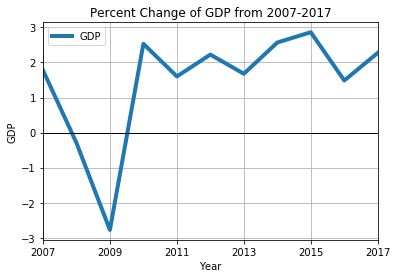

In [3]:
dfGDP = pd.read_csv('gdp_annual.csv')
df_GDP = get_GDP_visual(dfGDP)
df_GDP.plot(linewidth=4)
plt.grid(True)
plt.axhline(y=0,color='black',linestyle='-',lw=1)
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Percent Change of GDP from 2007-2017')

We can clearly see the affect of the financial crisis of 2008/2009 on GDP. We would expect to see more negative sentiment in our text data from these years. For the remaining years we can see relatively small fluctuations and steady positive growth rates. 

Next, we will explore the companies that appear most frequently in our analysis. There are a number of companies that appear over multiple years, most notably Exxon Mobil and Microsoft are in all 11 years. 

Text(0.5, 1.0, 'Frequency of Companies in the Top 10')

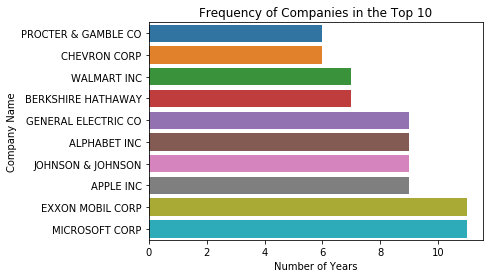

In [4]:
df_freq = getCompFreq(dftop10)
g = sns.barplot(x="Number of Years", y = 'Company Name', data=df_freq)
plt.title('Frequency of Companies in the Top 10')

# Hypothesis and Initial Modeling

Our hypothesis is that the text from the MD&A section of the top US companies provides significant predictive value for GDP. 

First we will combine our cleaned MDA text and our $y$ variable, GDP percent change.

In [5]:
dfClean = pd.read_pickle("Cleaned_MDA.pkl")
dfClean = getXy(dfClean)
dfClean.head(3)

,X,y
2007,exhibit financial statement schedule financial...,1.77857
2008,exhibit financial statement schedule financial...,-0.291621
2009,exhibit financial statement schedule financial...,-2.77553


Given the number of years in our analysis is somewhat limited, we will use kfold cross validation to fit the model.

In [6]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
kf = KFold(n_splits=5, random_state=2, shuffle=True)
X = np.array(dfClean['X'])
y = np.array(dfClean['y'])
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

We'll start by using word embeddings to try to pick up patterns in the text to predict GDP. After experimenting with different ngrams and found an ngram equal to (1,3) provides the best results. This model will consider ngrams of length 1 through length 3.  

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_df=.85)
train_X_vec = vectorizer.fit_transform(X_train).toarray()
test_X_vec = vectorizer.transform(X_test).toarray()

After experimenting with several models including linear and stochastic gradient descent regression, we found XG Boost to provide the best results.

In [8]:
model = xgb.XGBRegressor()
model.fit(train_X_vec, y_train)

[14:59:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

Let's see how we did...

In [9]:
print(y_test)
y_pred = model.predict(test_X_vec)
print(y_pred)
print(model.score(test_X_vec, y_test))
print(mean_absolute_error(y_test, y_pred))

[2.861587025 2.273338548]
[1.6886134 1.6276815]
-9.361573475582437
0.9093153322382201


We can see the actual GDP from the test data is 2.9 and 2.3 for the years 2015 and 2017 respectively and our predicted GDP of 2.5 and 1.5. We will use two metrics in the evaluation of models, mean absolute error (MAE) and $R^2$, refer to the formulaic expressions below. We choose to assess MAE over RMAE based on the increased interpretability of results that MAE provides. 

We can see from the above model the MAE is 0.57 with an $R^2$ of -3.2. The negative $R^2$ value tells our model performs worse than using the mean to make predictions on new y values. Clearly not a good result and we will need to explore a different method but use this as a baseline in order to compare results.

${MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$

$R^2(y, \hat{y})$ = 1 - $\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$ <br>
Where... <br>

$\bar{y}$ = $\frac{1}{n} \sum_{i=1}^{n} y_i$ <br>

$\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2$

# Sentiment Analysis

Our word embedding does not seem to be picking up on predictive patterns in the dataset, we'll now explore using sentiment analysis. For this work we will utilize the python library TextBlob, which returns a sentiment polarity score and a subjectivity score. The polarity score is a float value between -1 and 1, where -1 is highly negative and 1 is highly positive. The subjectivity score is from 0 to 1, where 1 is highly subjective and 0 is highly objective. 

The link provides the code for creating the pickled files seen in the analysis below [Model Analysis](Model_Analysis.ipynb)

Let's take a look at an example...

In [10]:
wordAnalysis = pd.read_pickle("word_analysis.pkl")

In [11]:
print(wordAnalysis['X'][0][1000])
print(wordAnalysis['X'][0][10002])

('due', -0.125, 0.375)
('consistent', 0.25, 0.25)


The first value given in each tuple is the polarity and the second is the subjectivity. We can see the two random words above have relatively low weights for both scores. 

We'll run sentiment analysis on an individual sentence level and a separate analysis using individual words using polarity scores.  We will remove words that have a score of 0 polarity, as these words do not factor into the overall polarity of a text. We'll use the ensemble method, XGBoost algorithm to make predictions.

**Individual Words**

In [12]:
# Extract the polarity values to run on individual scores and the summed scores
word_polarity = get_polarity(wordAnalysis.copy())

# split Xs into individual columns and run analysis
word_split_Xs = pd.DataFrame(word_polarity.X.tolist())
word_split = model_analysis(np.array(word_split_Xs),np.array(word_polarity['y']))

# get the sum of all the scores for each year and run analysis
summed_word = np.array(word_polarity['X'].map(lambda x: sum(x)))
Sum_word = model_analysis(summed_word,np.array(word_polarity['y']))

/Users/gameonsammy/Documents/GitHub/Sentiment_Analysis_SP_500/Sentiment_Analysis_Project/text_analysis.py:118: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  boost_rounds = cv_results['test-mae-mean'].argmin()


Best params: 3, 2, MAE: 1.3930202
[15:04:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: 3, 2, MAE: 1.1105224
[15:04:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/gameonsammy/Documents/GitHub/Sentiment_Analysis_SP_500/Sentiment_Analysis_Project/text_analysis.py:118: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  boost_rounds = cv_results['test-mae-mean'].argmin()


**Individual Sentences**

In [13]:
analysis_sentence = pd.read_pickle('sentence_analysis.pkl')
# Extract the polarity values to run on individual scores and the summed scores
sentence_polarity = get_polarity(analysis_sentence)

# split Xs into individual columns and run analysis
sentences_split_Xs = pd.DataFrame(sentence_polarity.X.tolist())
sentence_split = model_analysis(np.array(sentences_split_Xs),np.array(sentence_polarity['y']))

# get the sum of all the scores for each year and run analysis
summed_sentence = np.array(sentence_polarity['X'].map(lambda x: sum(x)))
Sum_sentence = model_analysis(summed_sentence,np.array(sentence_polarity['y']))

/Users/gameonsammy/Documents/GitHub/Sentiment_Analysis_SP_500/Sentiment_Analysis_Project/text_analysis.py:118: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  boost_rounds = cv_results['test-mae-mean'].argmin()


Best params: 3, 1, MAE: 1.7700652
[15:04:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: 3, 2, MAE: 1.5824678
[15:04:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/gameonsammy/Documents/GitHub/Sentiment_Analysis_SP_500/Sentiment_Analysis_Project/text_analysis.py:118: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  boost_rounds = cv_results['test-mae-mean'].argmin()


Now that we have fit the different models, let's see how the $R^2$ scores compare...

In [14]:
models = [word_split,Sum_word,sentence_split,Sum_sentence]
name = ['word_split','Sum_word','sentence_split','Sum_sentence']
for i in range(len(models)):
    print(name[i],models[i][2])

word_split [1.1145155 0.6550615]
Sum_word [2.165656 2.165656]
sentence_split [2.6631567 1.1569219]
Sum_sentence [2.141147 2.141147]


Again we can see that the models are not performing any better than what could be achieved by only predicting the mean values. However, it looks like summed version of individual words is performing the best.

Let's take another look at some words with higher subjectivity...

In [15]:
print(wordAnalysis['X'][0][105])
print(wordAnalysis['X'][0][143])

('crude', -0.7, 1.0)
('economically', 0.3, 0.9)


Note that the two words above score very high in subjectivity, this makes sense as the polarity of the individual word is not clear without context. The word crude is especially noteworthy, in an oil and gas context this word is typically used to reference crude oil and gas. Of course, this does not imply negativity in this context. We have seen above in the data exploration section, oil and gas companies Exxon Mobil and Chevron appear in numerous years of analysis. <br>

To take this into consideration we'll remove highly subjective words, those with scores 0.9 and greater. Refer to the table below for the word counts before any removal, the removal of the zero polarity scores, and the removal of the high subjectivity scores and the words dropped from each stage

In [16]:
word_count = pd.read_pickle("Word_count.pkl")
word_count

,Word Count,Words Dropped
Raw Data,2999162,0
Dropped Zeros,241435,2757727
Dropped High Subjectivity,218814,22621


**Visual Exploration of Transformed Data**

Let's take a look at the frequency of positive and negative sentiment...

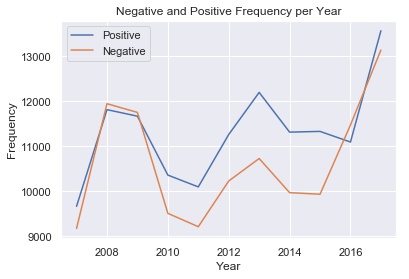

In [17]:
freqSent = pd.read_pickle("pos_neg_count.pkl")

x = [i for i in range(2007,2018)]
freqSent['Year'] = x

sns.set(style="darkgrid")
sns.lineplot(x='Year', y = 'Positive', 
            data=freqSent)
sns.lineplot(x='Year', y= 'Negative', data = freqSent).set(ylabel='Frequency')
plt.title('Negative and Positive Frequency per Year')
plt.legend(['Positive','Negative'])

The above graph shows the frequency count of positive and negative words per year. We can see for the majority of years, positive words appear more frequently than negative words. However, this is flipped in 2008, 2009 and 2016. This is expected in 2009 and 2010 however this change is unusual for the year 2016. One explanation for this could be the small company sample size included in the analysis. By narrowing the sentiment analysis to the top ten companies, variability in individual companies can have a large impact on the overall results. Alternatively, the negative sentiment may be picking up on other non-economic factors such as political changes and uncertainty.  

Now let's take a look at the ratio of negative to positive sentiment per year...

In [18]:
freqSent['Percent Negative'] = freqSent['Negative']/(freqSent['Negative']+freqSent['Positive'])

Text(0.5, 1.0, 'Percent Negative Text by Year')

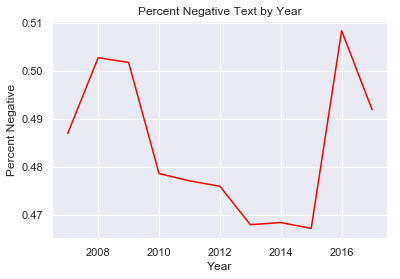

In [19]:
sns.lineplot(x='Year', y = 'Percent Negative', 
            data=freqSent, color='red')
plt.title('Percent Negative Text by Year')

Again, we see increases in the percent negative in 2008, 2009 and 2016. <br>

Now we'll take a look at the total scores opposed to frequency...

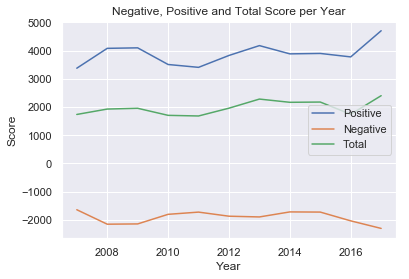

In [20]:
sum_score = pd.read_pickle("pos_neg_sum.pkl")
x = [i for i in range(2007,2018)]
sum_score['Year'] = x

sns.set(style="darkgrid")
sns.lineplot(x='Year', y = 'Positive',
            data=sum_score)
sns.lineplot(x='Year', y= 'Negative', data = sum_score).set(ylabel='Score')
sns.lineplot(x='Year', y= 'Total', data = sum_score).set(ylabel='Score')
plt.title('Negative, Positive and Total Score per Year')
plt.legend(['Positive','Negative','Total'])

Let's take a closer look at the total score...

Text(0.5, 1.0, 'Total Score per Year')

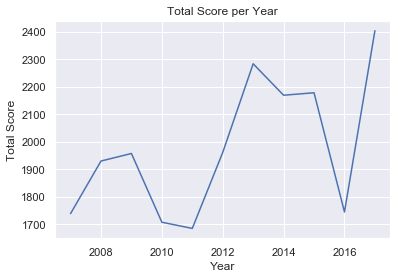

In [21]:
sns.lineplot(x='Year', y= 'Total', data = sum_score).set(ylabel='Total Score')
plt.title('Total Score per Year')

We can see from the plot above the sum of the companies score for each year. Overall, the scores are all positive, which is to be expected given that it is in the company's interest to report results in the most positive light possible. The results are within expectations given the economic conditions in the respective years with the exception of 2016 where we see a significant fall in the overall score. 

Now we will take a look at the year over year polarity distributions...

In [22]:
analysis_word = pd.read_pickle('word_analysis.pkl')

# the best parameters of the dataset for the model
word_polarity_low = low_subjectivity(analysis_word)
split_Xs = pd.DataFrame(word_polarity_low.X.tolist())
split_Xs.fillna(value=-2, inplace=True)

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2007')

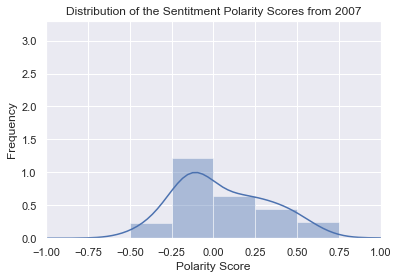

In [23]:
sns.distplot(split_Xs.iloc[:1],bins=12)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2007')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2008')

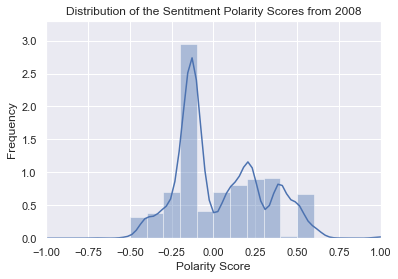

In [24]:
sns.distplot(split_Xs.iloc[1:2],bins=30)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2008')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2009')

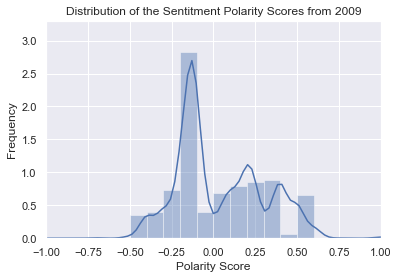

In [25]:
sns.distplot(split_Xs.iloc[2:3],bins=30)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2009')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2010')

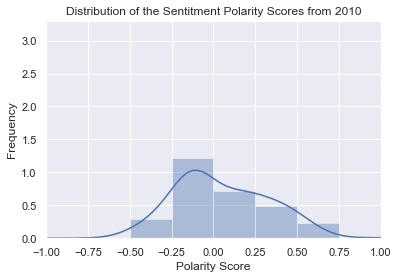

In [26]:
sns.distplot(split_Xs.iloc[3:4],bins=12)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2010')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2011')

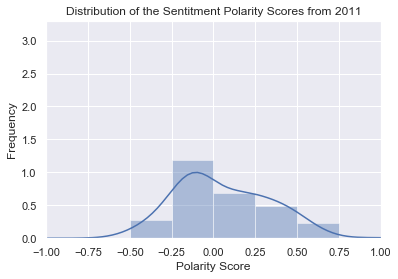

In [27]:
sns.distplot(split_Xs.iloc[4:5],bins=12)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2011')

We can see some interesting trends from 2007 through 2011. The polarity scores resemble that of a flattened normal distribution in 2007, 2010 and 2011, these years had positive GDP growth. When we look at the years 2008 and 2009, the years of negative GDP growth, we see a multimodal distribution with three distinct peaks. The most significant and sharpest peak is a negative polarity of around -0.1 for both years.   

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2012')

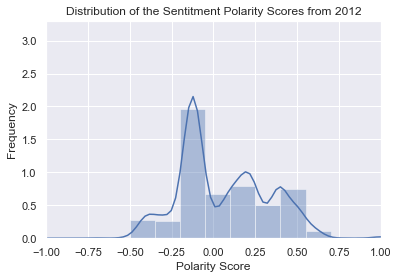

In [28]:
sns.distplot(split_Xs.iloc[5:6],bins=20)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2012')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2013')

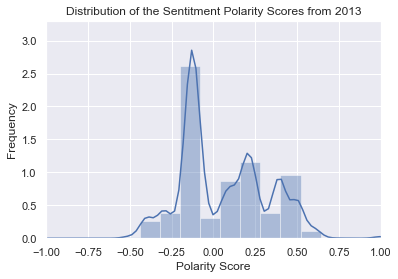

In [29]:
sns.distplot(split_Xs.iloc[6:7],bins=25)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2013')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2014')

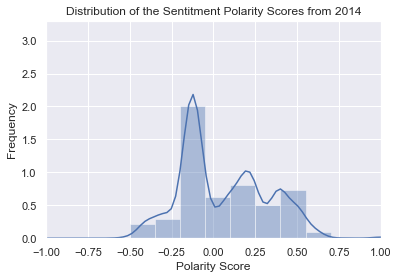

In [30]:
sns.distplot(split_Xs.iloc[7:8],bins=20)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2014')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2015')

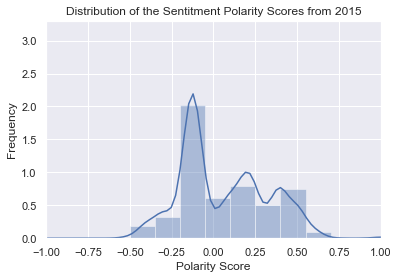

In [31]:
sns.distplot(split_Xs.iloc[8:9],bins=20)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2015')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2016')

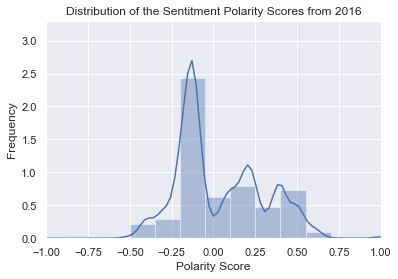

In [32]:
sns.distplot(split_Xs.iloc[9:10],bins=20)
plt.xlim(-1, 1)
plt.ylim(None,3.3)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2016')

Text(0.5, 1.0, 'Distribution of the Sentitment Polarity Scores from 2017')

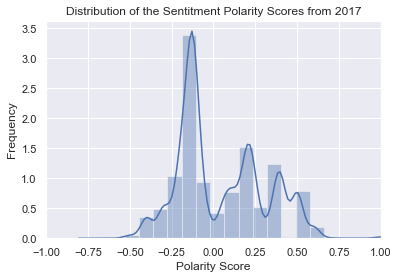

In [33]:
sns.distplot(split_Xs.iloc[10:],bins=20)
plt.xlim(-1, 1)
plt.grid(True)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of the Sentitment Polarity Scores from 2017')

Interestingly, 2012 through 2017 are multimodal distributions that are similar to the years of negative GDP growth in 2008 and 2009. If we focus on the height of the negative peak, we can notice higher peaks of around 2.5 to 3.3 in the years 2013, 2016 and 2017. Whereas, the peak in 2014 and 2015 is lower around 2.0. The lower negative polarity seems to align with a growing GDP in 2014 and 2015, however our distribution for 2017 shows the highest and most dramatic increase in negative polarity. In the year 2017 we also see an increase in the positive peaks, which is why we see an overall high positive score for 2017. 

### Model and Evaluation 

**Hyperparameter Tunning**

We'll use the built in cross validation in the XG Boost library to validate our max_depth and min_child_weight parameters. Max depth tells us the maximum height of the tree, while min child weight tells us the minimum weight required to create a new node in the tree. We chose to tune these parameters as they are used to control the complexity of the model. Further, we'll run the model with the high subjectivity, 0.9 or greater removed. 

In [34]:
analysis_word = pd.read_pickle('word_analysis.pkl')
# the best parameters of the dataset for the model
word_polarity_low = low_subjectivity(analysis_word)

# get the sum of all the scores for each year
summed_word_low = np.array(word_polarity_low['X'].map(lambda x: sum(x)))


We fit the summed version of individual words excluding high subjectivity on the XGBoost model, we tuned the parameters for the model using cross-validation and the results were...

In [35]:
Sum_word_best = model_analysis(summed_word_low,np.array(word_polarity_low['y']))
print('Best score: ',Sum_word_best[1])
print('MAE: ', Sum_word_best[3])
print('Actual y: ',Sum_word_best[4],'Predicted y: ',Sum_word_best[2])

Best params: 3, 1, MAE: 0.8797166000000001
[15:05:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score:  0.48268473842849385
MAE:  0.17202351934149163
Actual y:  [2.861587025 2.273338548] Predicted y:  [2.566436  2.2244425]


/Users/gameonsammy/Documents/GitHub/Sentiment_Analysis_SP_500/Sentiment_Analysis_Project/text_analysis.py:118: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  boost_rounds = cv_results['test-mae-mean'].argmin()


Cross-validation yeilded parameters of max depth equal to 3 and min child weight of 1. The model provided us with our best $R^2$ score of 0.482. With the predicted y values of 2.57 and 2.22 for 2015 and 2017 resepctively, and the actual percent change of GDP being 2.86 and 2.27. <br>

Removing words with higher subjectivity and zero polarity significantly increased the explanatory power of the model. With a mean absolute error of just 0.17 our model appears to have picked up on patterns in the underlying sentiment each year as it relates to GDP. 

# Conclusion

While our final model's $R^2$ score is not exceptional, the model's MAE is quite impressive. Based on the results further investigation into the predictive capabilities of sentiment in public companies on GDP is warranted. <br>

While the results produced in this report are promising, we should keep in mind several limiting factors to our analysis. First of all, the volume of data as far as number of years and number of companies is low. We would expect the addition of more S&P 500 companies to normalize the distributions and potentially lead to more accurate and robust models. Since the company size is small, company specific fluctuations in sentiment year over year have a significant impact on the overall distribution and these may not be indicative of economic growth. Moreover, the number of years in this report is limited to 2007-2017. More years would allow for increased training and validation data. <br>

With these limiting factors in mind, we can be cautiously optimistic of the GDP predicting capability of future models trained on the sentiment of S&P 500 companies.